In [1]:
import os
spark_home = os.path.abspath(os.getcwd() + "/spark/spark-3.5.5-bin-hadoop3")
hadoop_home = os.path.abspath(os.getcwd() + "/spark/winutils")
print(f"I am using the following SPARK_HOME: {spark_home}")
if os.name == 'nt':
    os.environ["HADOOP_HOME"] = f"{hadoop_home}"
    print(f"Windows detected: set HADOOP_HOME to: {os.environ['HADOOP_HOME']}")
    hadoop_bin = os.path.join(hadoop_home, "bin")
    os.environ["PATH"] = f"{hadoop_bin};{os.environ['PATH']}"
    print(f"  Also added Hadoop bin directory to PATH: {hadoop_bin}")

import findspark
import pyspark
from pyspark.streaming import StreamingContext

findspark.init(spark_home)
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession.builder.getOrCreate()


I am using the following SPARK_HOME: d:\OneDrive - CGIAR\Master\Advanced Analytics\assignments\assignment-03\spark\spark-3.5.5-bin-hadoop3
Windows detected: set HADOOP_HOME to: d:\OneDrive - CGIAR\Master\Advanced Analytics\assignments\assignment-03\spark\winutils
  Also added Hadoop bin directory to PATH: d:\OneDrive - CGIAR\Master\Advanced Analytics\assignments\assignment-03\spark\winutils\bin


In [2]:
papers_df = spark.read.json("data/interim")


# Data structure

Understand what you have and whether it's clean:
- What is the schema of the dataset?
- Are there missing values in key fields like title, summary, main_category, categories, or published?
- Are there duplicated records (aid)?

In [3]:
# Schema
papers_df.printSchema()

# Get basic statistics and information
print(f"Dataset size: {papers_df.count()} papers")
print(f"Number of columns: {len(papers_df.columns)}")

# Check for missing values
from pyspark.sql.functions import col, count, when, isnan, isnull
from pyspark.sql.functions import split, size, year, month, explode, round, sum as spark_sum

papers_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) 
                          for c in papers_df.columns]).show()


root
 |-- aid: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- published: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- title: string (nullable = true)

Dataset size: 4442 papers
Number of columns: 6
+---+----------+-------------+---------+-------+-----+
|aid|categories|main_category|published|summary|title|
+---+----------+-------------+---------+-------+-----+
|  0|         0|            0|        0|      0|    0|
+---+----------+-------------+---------+-------+-----+



# Main category distribution

Understand your labels before deciding on prediction strategy:
- How many unique values are there in `main_category`?
- What are the top N most frequent `main_category` values?
- Are some `main_category` values very rare or dominant? (e.g., does one class dominate 50% of the data?)
- How many unique `categories` values?
- What’s the average number of `categories` per paper (for multilabel setup)?
- How do `main_category` distributions differ over week?
- What's the distribution of Arxiv main category (before `.`)?


In [4]:
# Target Analysis: Main Category Distribution and Characteristics# Target Analysis: Main Category Distribution and Characteristics

# ---------- 1. Count unique values in main_category ----------
unique_main_categories = papers_df.select("main_category").distinct().count()
print(f"Number of unique main_categories: {unique_main_categories}")


Number of unique main_categories: 143


In [5]:
# ---------- 2. Top N most frequent main_categories ----------
N = 10  # Change this to see more or fewer categories
main_cat_dist = papers_df.groupBy("main_category").count().orderBy("count", ascending=False)
print(f"\nTop {N} most frequent main categories:")
main_cat_dist.show(N, truncate=False)



Top 10 most frequent main categories:
+-----------------+-----+
|main_category    |count|
+-----------------+-----+
|cs.CV            |511  |
|cs.LG            |295  |
|cs.CL            |234  |
|quant-ph         |195  |
|cs.RO            |118  |
|cs.AI            |108  |
|math.AP          |94   |
|eess.SY          |91   |
|cond-mat.mtrl-sci|90   |
|hep-ph           |84   |
+-----------------+-----+
only showing top 10 rows



In [6]:
# ---------- 3. Check for category imbalance ----------
total_papers = papers_df.count()
main_cat_dist_with_pct = main_cat_dist.withColumn(
    "percentage", round((col("count") / total_papers) * 100, 2)
)

print("\nCategory distribution with percentages:")
main_cat_dist_with_pct.show(20, truncate=False)

# Find dominant categories (>10%) and rare categories (<1%)
dominant_categories = main_cat_dist_with_pct.filter("percentage > 5")
rare_categories = main_cat_dist_with_pct.filter("percentage < 1")

print(f"Dominant categories (>5%): {dominant_categories.count()}")
dominant_categories.show(truncate=False)

print(f"Rare categories (<1%): {rare_categories.count()}")
rare_categories.show(truncate=False)



Category distribution with percentages:
+-----------------+-----+----------+
|main_category    |count|percentage|
+-----------------+-----+----------+
|cs.CV            |511  |11.5      |
|cs.LG            |295  |6.64      |
|cs.CL            |234  |5.27      |
|quant-ph         |195  |4.39      |
|cs.RO            |118  |2.66      |
|cs.AI            |108  |2.43      |
|math.AP          |94   |2.12      |
|eess.SY          |91   |2.05      |
|cond-mat.mtrl-sci|90   |2.03      |
|hep-ph           |84   |1.89      |
|math.OC          |73   |1.64      |
|gr-qc            |70   |1.58      |
|physics.optics   |69   |1.55      |
|eess.SP          |68   |1.53      |
|math.CO          |67   |1.51      |
|astro-ph.GA      |66   |1.49      |
|cs.CR            |62   |1.4       |
|hep-th           |61   |1.37      |
|cond-mat.mes-hall|60   |1.35      |
|math.NA          |59   |1.33      |
+-----------------+-----+----------+
only showing top 20 rows

Dominant categories (>5%): 3
+-------------+-

In [7]:
# ---------- 4. Unique subcategories in categories field ----------
# Assuming categories field contains comma-separated category codes
categories_exploded = papers_df.select(
    explode(split(col("categories"), ",")).alias("subcategory")
)
unique_subcategories = categories_exploded.select("subcategory").distinct().count()
print(f"\nNumber of unique subcategories: {unique_subcategories}")



Number of unique subcategories: 185


In [8]:
from pyspark.sql.functions import concat, lit

cat_dist_with_count = papers_df.withColumn(
    "num_categories", size(split(col("categories"), ","))
)

avg_labels = cat_dist_with_count.agg(
    {"num_categories": "avg"}
).collect()[0][0]

print(f"\nAverage number of categories per paper: {avg_labels:.2f}")

category_dist = cat_dist_with_count.groupBy("num_categories").count()

# Add percentage column
category_dist_with_pct = category_dist.withColumn(
    "percentage", round((col("count") / total_papers) * 100, 2)
)

# Format the output to include both count and percentage
print("\nDistribution of number of categories per paper:")
category_dist_with_pct.select(
    "num_categories", 
    "count", 
    concat(col("percentage").cast("string"), lit("%")).alias("percentage")
).orderBy("num_categories").show(20)



Average number of categories per paper: 1.77

Distribution of number of categories per paper:
+--------------+-----+----------+
|num_categories|count|percentage|
+--------------+-----+----------+
|             1| 2183|    49.14%|
|             2| 1438|    32.37%|
|             3|  590|    13.28%|
|             4|  153|     3.44%|
|             5|   64|     1.44%|
|             6|   12|     0.27%|
|             7|    2|     0.05%|
+--------------+-----+----------+



In [10]:
# ---------- 6. Category distributions over week ----------
from pyspark.sql.functions import weekofyear, date_format, dayofweek, date_sub, expr, to_date

# Convert published field to date components and find the Monday that starts each week
papers_with_date = papers_df.withColumn(
    "pub_date", to_date(col("published"))
).withColumn(
    # Calculate days to subtract to get to Monday (Sunday=1, Monday=2, etc.)
    # For Monday (2) we subtract 0, Tuesday (3) subtract 1, etc.
    "days_from_monday", expr("dayofweek(pub_date) - 2")
).withColumn(
    # Handle Sunday (need to subtract 6 days instead of -1)
    "days_from_monday", 
    when(col("days_from_monday") < 0, 6).otherwise(col("days_from_monday"))
).withColumn(
    # Get the Monday date
    "week_start", date_sub(col("pub_date"), col("days_from_monday"))
).withColumn(
    # Format it as "Mar-31" 
    "week_date", date_format(col("week_start"), "MMM-d")
)

# Count papers by week and category
weekly_cat_dist = papers_with_date.groupBy("week_date", "main_category").count().orderBy("week_date", "count", ascending=False)

# print("\nCategory distribution by week (showing first 20 rows):")
# weekly_cat_dist.show(20, truncate=False)

# Calculate percentage distribution by week
weekly_totals = papers_with_date.groupBy("week_date").count().withColumnRenamed("count", "week_total")

weekly_cat_pct = weekly_cat_dist.join(weekly_totals, "week_date") \
    .withColumn("percentage", round((col("count") / col("week_total")) * 100, 2)) \
    .orderBy("week_date", "percentage", ascending=False)

# print("\nPercentage distribution of categories by week (showing first 20 rows):")
# weekly_cat_pct.select("week_date", "main_category", "count", "week_total", "percentage").show(20, truncate=False)

# Optional: Track specific categories over time
top_categories = main_cat_dist.limit(10).select("main_category").rdd.flatMap(lambda x: x).collect()
top_cat_trend = weekly_cat_pct.filter(col("main_category").isin(top_categories))

print("\nTrend for top 10 categories over time (by week):")
top_cat_trend.orderBy("week_date", "main_category").show(50, truncate=False)

# Add a visualization hint
print("\nNote: The week_date format is 'MMM-d' showing the Monday that starts each week")



Trend for top 10 categories over time (by week):
+---------+-----------------+-----+----------+----------+
|week_date|main_category    |count|week_total|percentage|
+---------+-----------------+-----+----------+----------+
|Apr-7    |cond-mat.mtrl-sci|49   |2344      |2.09      |
|Apr-7    |cs.AI            |63   |2344      |2.69      |
|Apr-7    |cs.CL            |128  |2344      |5.46      |
|Apr-7    |cs.CV            |255  |2344      |10.88     |
|Apr-7    |cs.LG            |153  |2344      |6.53      |
|Apr-7    |cs.RO            |71   |2344      |3.03      |
|Apr-7    |eess.SY          |46   |2344      |1.96      |
|Apr-7    |hep-ph           |51   |2344      |2.18      |
|Apr-7    |math.AP          |58   |2344      |2.47      |
|Apr-7    |quant-ph         |101  |2344      |4.31      |
|Mar-24   |cond-mat.mtrl-sci|2    |125       |1.6       |
|Mar-24   |cs.AI            |2    |125       |1.6       |
|Mar-24   |cs.CL            |11   |125       |8.8       |
|Mar-24   |cs.CV      

In [12]:
import plotly.express as px
import pandas as pd

# Convert Spark DataFrame to Pandas and prepare data
top_cat_pandas = top_cat_trend.orderBy("week_date", "main_category").toPandas()

# Create line chart with Plotly
fig = px.line(
    top_cat_pandas, 
    x='week_date', 
    y='percentage', 
    color='main_category',
    markers=True,
    title='Weekly Trends of Top 10 Categories',
    labels={'week_date': 'Week', 'percentage': 'Percentage (%)'}
)

# Basic layout improvements
fig.update_layout(
    xaxis=dict(tickangle=45),
    yaxis=dict(ticksuffix='%'),
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='top', # Anchor to bottom of legend box
        y=1.02,          # Position just above the plot area
        xanchor='center', # Center horizontally
        x=0.5
    ),
    margin=dict(t=50),   # Add top margin for legend space
    template='plotly_white'
)

# Show the plot
fig.show(render="png")


In [13]:
# ---------- 7. Archive distribution ----------

arxiv_main_category = {
    "astro-ph": [
        "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE",
        "astro-ph.IM", "astro-ph.SR"
    ],
    "cond-mat": [
        "cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci",
        "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft",
        "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"
    ],
    "gr-qc": [
        "gr-qc"
    ],
    "hep": [
        "hep-ex", "hep-lat", "hep-ph", "hep-th"
    ],
    "math-ph": [
        "math-ph"
    ],
    "nlin": [
        "nlin.AO", "nlin.CG", "nlin.CD", "nlin.SI", "nlin.PS"
    ],
    "nucl": [
        "nucl-ex", "nucl-th"
    ],
    "quant-ph": [
        "quant-ph"
    ],
    "physics": [
        "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus",
        "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph",
        "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn",
        "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det",
        "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph",
        "physics.soc-ph", "physics.space-ph"
    ],
    "math": [
        "math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO",
        "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM",
        "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT",
        "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA",
        "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG",
        "math.SP", "math.ST"
    ],
    "cs": [
        "cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV",
        "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL",
        "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO",
        "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS",
        "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"
    ],
    "q-bio": [
        "q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT",
        "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"
    ],
    "q-fin": [
        "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR",
        "q-fin.RM", "q-fin.ST", "q-fin.TR"
    ],
    "stat": [
        "stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"
    ],
    "eess": [
        "eess.AS", "eess.IV", "eess.SP", "eess.SY"
    ],
    "econ": [
        "econ.EM", "econ.GN", "econ.TH"
    ],
}

from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Create mapping with dictionary comprehension
category_to_parent = {child: parent for parent, children in arxiv_main_category.items() for child in children}

# Define mapping UDF
@udf(StringType())
def map_category(category):
    return category_to_parent.get(category, "other")

# Add column with single function call
papers_with_categories = papers_df.withColumn("arxiv_main_category", map_category(col("main_category")))


Number of unique arxiv_main_categories: 16

ArXiv Main Category Distribution:
+-------------------+-----+----------+
|arxiv_main_category|count|percentage|
+-------------------+-----+----------+
|cs                 |1868 |42.05     |
|math               |765  |17.22     |
|cond-mat           |323  |7.27      |
|astro-ph           |290  |6.53      |
|physics            |284  |6.39      |
|eess               |209  |4.71      |
|quant-ph           |195  |4.39      |
|hep                |182  |4.1       |
|stat               |94   |2.12      |
|gr-qc              |70   |1.58      |
|nucl               |55   |1.24      |
|econ               |34   |0.77      |
|q-bio              |31   |0.7       |
|nlin               |16   |0.36      |
|q-fin              |14   |0.32      |
|math-ph            |12   |0.27      |
+-------------------+-----+----------+


Class Imbalance Ratio (max/min): 155.67
Classes with <1% representation: 5


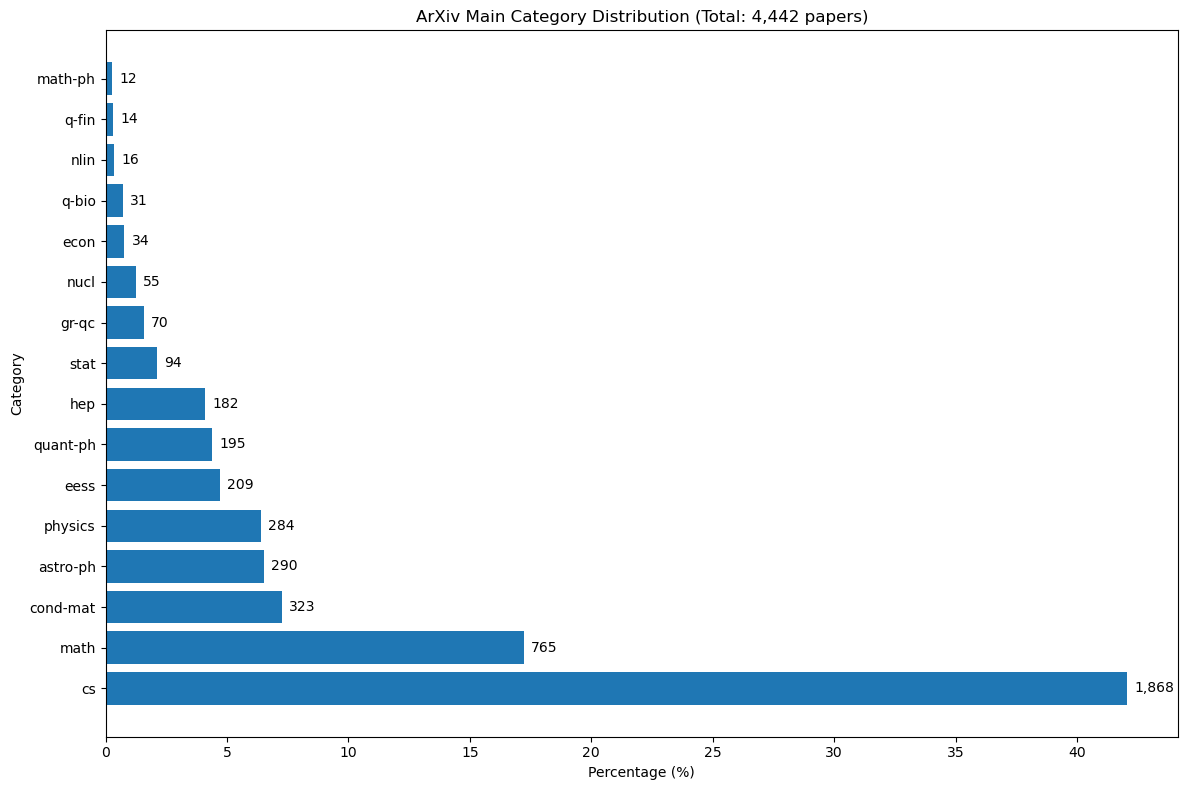

In [14]:
# Get distribution of arxiv_main_category
from pyspark.sql.functions import col, count, round

# Count the unique arxiv_main_category values
unique_arxiv_main_categories = papers_with_categories.select("arxiv_main_category").distinct().count()
print(f"Number of unique arxiv_main_categories: {unique_arxiv_main_categories}")


# Count categories and calculate percentages
total_papers = papers_with_categories.count()
cat_distribution = papers_with_categories.groupBy("arxiv_main_category") \
    .count() \
    .withColumn("percentage", round((col("count") / total_papers) * 100, 2)) \
    .orderBy("count", ascending=False)

# Display distribution
print("\nArXiv Main Category Distribution:")
cat_distribution.show(truncate=False)

# Check class imbalance
max_count = cat_distribution.agg({"count": "max"}).collect()[0][0]
min_count = cat_distribution.agg({"count": "min"}).collect()[0][0]
print(f"\nClass Imbalance Ratio (max/min): {max_count/min_count:.2f}")

# Count classes with less than 1% representation
rare_classes = cat_distribution.filter("percentage < 1").count()
print(f"Classes with <1% representation: {rare_classes}")

# Optional: Quick visualization using pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas for easy plotting
pd_distribution = cat_distribution.toPandas()

# Create horizontal bar chart
plt.figure(figsize=(12, 8))  # Slightly larger figure to accommodate annotations
bars = plt.barh(pd_distribution['arxiv_main_category'], pd_distribution['percentage'])
plt.xlabel('Percentage (%)')
plt.ylabel('Category')
plt.title(f'ArXiv Main Category Distribution (Total: {total_papers:,} papers)')

# Add count annotations to each bar
for i, bar in enumerate(bars):
    count = pd_distribution.iloc[i]['count']
    plt.text(
        bar.get_width() + 0.3,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height()/2,  # Vertical center of the bar
        f'{count:,}',  # Format with commas for thousands
        va='center'  # Vertically centered
    )

plt.tight_layout()
plt.show()


# Input features

Evaluate your input features `title` and `summary`:
- What is the average/median/min/max length (in words or characters) of:
    - title
    - summary
    - title + summary?
- Are there unusually short or long texts that should be filtered?
- Are there stopwords or LaTeX/math formatting (\\mathsf, etc.) that should be removed?
- Are there phrases or token patterns in title and summary that can be related to `main_category`?


In [15]:
from pyspark.sql.functions import length, size, split, col, expr, percentile_approx
from pyspark.sql.functions import min as spark_min, max as spark_max, avg as spark_avg
from pyspark.sql.functions import regexp_extract, regexp_replace
from pyspark.ml.feature import StopWordsRemover, NGram, CountVectorizer, Tokenizer

# ---------- 1. Text Length Statistics ----------
text_stats = papers_df.select(
    length("title").alias("title_chars"),
    size(split("title", " ")).alias("title_words"),
    length("summary").alias("summary_chars"),
    size(split("summary", " ")).alias("summary_words")
).withColumn(
    "combined_chars", col("title_chars") + col("summary_chars")
).withColumn(
    "combined_words", col("title_words") + col("summary_words")
)

# Calculate statistics
stats = text_stats.agg(
    spark_min("title_chars"), spark_max("title_chars"), spark_avg("title_chars"), percentile_approx("title_chars", 0.5),
    spark_min("title_words"), spark_max("title_words"), spark_avg("title_words"),
    spark_min("summary_chars"), spark_max("summary_chars"), spark_avg("summary_chars"), 
    spark_min("summary_words"), spark_max("summary_words"), spark_avg("summary_words"),
    spark_min("combined_chars"), spark_max("combined_chars"), spark_avg("combined_chars"),
    spark_min("combined_words"), spark_max("combined_words"), spark_avg("combined_words")
).collect()[0]

print("\nText Statistics (min, max, avg):")
print(f"Title: {stats[0]}-{stats[1]} chars ({stats[2]:.1f} avg), {stats[4]}-{stats[5]} words ({stats[6]:.1f} avg)")
print(f"Summary: {stats[7]}-{stats[8]} chars ({stats[9]:.1f} avg), {stats[10]}-{stats[11]} words ({stats[12]:.1f} avg)")
print(f"Combined: {stats[13]}-{stats[14]} chars ({stats[15]:.1f} avg), {stats[16]}-{stats[17]} words ({stats[18]:.1f} avg)")



Text Statistics (min, max, avg):
Title: 12-242 chars (81.2 avg), 1-33 words (10.8 avg)
Summary: 104-2168 chars (1163.1 avg), 13-294 words (147.3 avg)
Combined: 140-2233 chars (1244.4 avg), 17-305 words (158.1 avg)


In [16]:
# ---------- 2. Identify Outliers (1st/99th percentiles) ----------
percentiles = text_stats.select(
    percentile_approx("title_chars", [0.01, 0.99]).alias("title_thresholds"),
    percentile_approx("summary_chars", [0.01, 0.99]).alias("summary_thresholds")
).collect()[0]

print(f"\nOutlier thresholds (1st-99th percentiles):")
print(f"Title length: {percentiles[0][0]}-{percentiles[0][1]} chars")
print(f"Summary length: {percentiles[1][0]}-{percentiles[1][1]} chars")



Outlier thresholds (1st-99th percentiles):
Title length: 27-155 chars
Summary length: 273-1913 chars


In [17]:
# ---------- 3. Check for LaTeX and Math formatting ----------
latex_pattern = r'\\[a-zA-Z]+'
latex_counts = papers_df.select(
    (size(expr(f"regexp_extract_all(title, '{latex_pattern}', 0)")) > 0).cast("int").alias("title_has_latex"),
    (size(expr(f"regexp_extract_all(summary, '{latex_pattern}', 0)")) > 0).cast("int").alias("summary_has_latex")
).agg(
    spark_sum("title_has_latex"), 
    spark_sum("summary_has_latex")
).collect()[0]

print(f"\nLaTeX Usage:")
print(f"Papers with LaTeX in title: {latex_counts[0]} ({latex_counts[0]/papers_df.count()*100:.1f}%)")
print(f"Papers with LaTeX in summary: {latex_counts[1]} ({latex_counts[1]/papers_df.count()*100:.1f}%)")



LaTeX Usage:
Papers with LaTeX in title: 0 (0.0%)
Papers with LaTeX in summary: 0 (0.0%)


In [18]:
from pyspark.sql.functions import explode, col, count as spark_count, trim, lower, regexp_replace

# 1. Better text cleaning before processing
clean_papers = papers_df.withColumn(
    "clean_title", 
    trim(regexp_replace(lower(col("title")), "[^a-zA-Z0-9\\s]", " "))
)

# 2. Apply tokenization pipeline
tokenizer = Tokenizer(inputCol="clean_title", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
bigram = NGram(n=2, inputCol="filtered", outputCol="bigrams")

# 3. Generate and filter meaningful bigrams
pipeline_result = bigram.transform(remover.transform(tokenizer.transform(clean_papers)))
bigram_counts = pipeline_result.select(
    explode("bigrams").alias("bigram")
).filter(
    # Multiple filters to ensure quality bigrams
    (length(trim(col("bigram"))) > 3) &                   # Reasonable length
    (~col("bigram").contains("  ")) &                     # No double spaces
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))   # Start/end with alphanumeric
).groupBy(
    "bigram"
).agg(
    spark_count("*").alias("count")
).orderBy(
    col("count").desc()
)

# 4. Show results
print("\nTop 10 bigrams in titles:")
for row in bigram_counts.limit(10).collect():
    print(f"'{row.bigram}': {row['count']}")
    


Top 10 bigrams in titles:
'language models': 94
'large language': 68
'reinforcement learning': 48
'machine learning': 47
'neural networks': 43
'black hole': 29
'deep learning': 27
'vision language': 26
'large scale': 25
'two dimensional': 24


In [19]:
from pyspark.sql.functions import explode, col, count as spark_count

# 1. Process all papers once with category information
category_bigrams = clean_papers.select(
    "main_category", 
    "clean_title"
).transform(
    # Apply the same pipeline to all papers at once
    lambda df: bigram.transform(remover.transform(tokenizer.transform(df)))
)

# 2. Extract, filter and count bigrams with categories in one operation
bigram_by_category = category_bigrams.select(
    "main_category",
    explode("bigrams").alias("bigram")
).filter(
    # Apply same quality filters as main analysis 
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "main_category", "bigram"
).count().orderBy(
    col("main_category"), col("count").desc()
)

# 3. Display top bigrams for selected categories in one efficient loop
top_categories = papers_df.groupBy("main_category").count() \
                          .orderBy("count", ascending=False) \
                          .limit(10) \
                          .select("main_category") \
                          .rdd.flatMap(lambda x: x).collect()


print("\nTop 5 bigrams per category:")
for category in top_categories[:10]:
    print(f"\n{category}:")
    top_for_category = bigram_by_category.filter(col("main_category") == category).limit(5).collect()
    for row in top_for_category:
        print(f"  '{row.bigram}': {row['count']}")


Top 5 bigrams per category:

cs.CV:
  'vision language': 18
  'language models': 12
  'gaussian splatting': 11
  'zero shot': 10
  'object detection': 10

cs.LG:
  'reinforcement learning': 24
  'neural networks': 15
  'time series': 13
  'language models': 9
  'machine learning': 8

cs.CL:
  'language models': 49
  'large language': 32
  'retrieval augmented': 11
  'test time': 6
  'augmented generation': 6

quant-ph:
  'variational quantum': 8
  'quantum circuits': 4
  'quantum dynamics': 4
  'quantum error': 4
  'machine learning': 4

cs.RO:
  'reinforcement learning': 6
  'motion planning': 4
  'human robot': 4
  'autonomous driving': 4
  'vision language': 3

cs.AI:
  'language models': 6
  'large language': 5
  'generative ai': 4
  'reinforcement learning': 4
  'llm based': 4

math.AP:
  'schr dinger': 8
  'parabolic equations': 4
  'solutions two': 3
  'minkowski problem': 3
  'wave equation': 3

eess.SY:
  'multi agent': 5
  'predictive control': 4
  'agent systems': 4
  'line

In [20]:
from pyspark.sql.functions import explode, col, count as spark_count, trim, lower, regexp_replace, length

# ----------------- Summary Bigram Analysis -----------------

# 1. Clean the summary text
clean_papers_summary = papers_df.withColumn(
    "clean_summary", 
    trim(regexp_replace(lower(col("summary")), "[^a-zA-Z0-9\\s]", " "))
)

# 2. Apply tokenization pipeline
sum_tokenizer = Tokenizer(inputCol="clean_summary", outputCol="summary_tokens")
sum_remover = StopWordsRemover(inputCol="summary_tokens", outputCol="summary_filtered")
sum_bigram = NGram(n=2, inputCol="summary_filtered", outputCol="summary_bigrams")

# 3. Generate and filter meaningful bigrams
summary_pipeline = sum_bigram.transform(
    sum_remover.transform(
        sum_tokenizer.transform(clean_papers_summary)
    )
)

# 4. Extract and count bigrams
summary_bigram_counts = summary_pipeline.select(
    explode("summary_bigrams").alias("bigram")
).filter(
    # Same quality filters as used for titles
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "bigram"
).agg(
    spark_count("*").alias("count")
).orderBy(
    col("count").desc()
)

# 5. Show top bigrams in summaries
print("\nTop 10 bigrams in summaries:")
for row in summary_bigram_counts.limit(10).collect():
    print(f"'{row.bigram}': {row['count']}")

# 6. Category-specific summary bigrams in a single efficient operation
category_summary_bigrams = clean_papers_summary.select(
    "main_category",
    "clean_summary"
).transform(
    # Apply the pipeline to all papers at once
    lambda df: sum_bigram.transform(sum_remover.transform(sum_tokenizer.transform(df)))
)

# 7. Process all categories at once
summary_bigrams_by_category = category_summary_bigrams.select(
    "main_category",
    explode("summary_bigrams").alias("bigram")
).filter(
    # Same quality filters
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "main_category", "bigram"
).count().orderBy(
    col("main_category"), col("count").desc()
)

# 8. Display top summary bigrams by category
print("\nTop 5 summary bigrams per category:")
for category in top_categories[:5]:  # Limiting to top 5 categories for brevity
    print(f"\n{category}:")
    top_for_category = summary_bigrams_by_category.filter(col("main_category") == category).limit(5).collect()
    for row in top_for_category:
        print(f"  '{row.bigram}': {row['count']}")
        


Top 10 bigrams in summaries:
'state art': 531
'real world': 448
'language models': 447
'large language': 384
'large scale': 266
'machine learning': 223
'experimental results': 218
'extensive experiments': 197
'fine tuning': 197
'real time': 197

Top 5 summary bigrams per category:

cs.CV:
  'state art': 223
  'real world': 139
  'extensive experiments': 114
  'github com': 88
  'high quality': 84

cs.LG:
  'reinforcement learning': 67
  'state art': 65
  'machine learning': 59
  'real world': 58
  'neural networks': 49

cs.CL:
  'language models': 179
  'large language': 152
  'fine tuning': 52
  'state art': 40
  'real world': 33

quant-ph:
  'quantum computing': 29
  'quantum systems': 26
  'variational quantum': 25
  'ground state': 23
  'quantum algorithms': 21

cs.RO:
  'real world': 55
  'real time': 25
  'experimental results': 20
  'motion planning': 19
  'imitation learning': 18


In [21]:
# Are certain keywords more correlated with certain categories?

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, expr, udf
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml import Pipeline

# 1. Prepare data - clean text and add category
keyword_data = papers_df.select(
    "main_category",
    regexp_replace(lower(col("title")), "[^a-zA-Z0-9\\s]", " ").alias("cleaned_text")
)

# 2. Create ML pipeline for feature extraction
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

# 3. Fit the pipeline and transform data
model = pipeline.fit(keyword_data)
transformed = model.transform(keyword_data)

# 4. Calculate keyword significance for each category
# Get vocabulary from the HashingTF model (using the vocabulary from token counts)
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="filtered", outputCol="counts", minDF=10)
cv_model = cv.fit(transformed)
vocab = cv_model.vocabulary

# 5. For each category, find most distinctive keywords
print("\nTop keywords correlated with categories:")
for category in top_categories[:10]:  # Show top 20 categories
    # Filter for this category and collect weighted term frequencies
    category_docs = transformed.filter(col("main_category") == category)
    
    # Extract top terms for this category using the TF-IDF weights
    @udf(returnType=ArrayType(StringType()))
    def get_top_terms(words, features):
        # Pair words with their feature weights and sort by weight
        return [w for _, w in sorted([(features[i], w) for i, w in enumerate(words) if i < len(features)], 
                                   key=lambda x: x[0], reverse=True)[:10]]
    
    # Apply the UDF to get top terms for each document
    category_terms = category_docs.withColumn("top_terms", get_top_terms("filtered", "features"))
    
    # Count term frequency across all documents in this category
    top_terms = category_terms.select(explode("filtered").alias("term")).groupBy("term").count()
    
    # Get overall corpus frequency for comparison
    corpus_freq = transformed.select(explode("filtered").alias("term")).groupBy("term").count().withColumnRenamed("count", "corpus_count")
    
    # Calculate term importance as ratio of category frequency to corpus frequency
    term_importance = top_terms.join(corpus_freq, "term").withColumn(
        "importance", col("count") / col("corpus_count")
    ).orderBy("importance", ascending=False)
    
    # Display results
    print(f"\n{category}:")
    for row in term_importance.filter(col("count") > 5).limit(10).collect():
        print(f"  '{row.term}': {row['count']} occurrences, {row.importance:.2f} importance")



Top keywords correlated with categories:

cs.CV:
  'pose': 9 occurrences, 0.90 importance
  'anything': 7 occurrences, 0.88 importance
  'grounding': 7 occurrences, 0.88 importance
  'video': 67 occurrences, 0.86 importance
  'monocular': 6 occurrences, 0.86 importance
  'restoration': 6 occurrences, 0.86 importance
  'controllable': 6 occurrences, 0.86 importance
  'visual': 38 occurrences, 0.81 importance
  'r1': 8 occurrences, 0.80 importance
  'segmentation': 51 occurrences, 0.77 importance

cs.LG:
  'unlearning': 6 occurrences, 0.75 importance
  'federated': 16 occurrences, 0.64 importance
  'forecasting': 10 occurrences, 0.59 importance
  'series': 14 occurrences, 0.48 importance
  'reinforcement': 26 occurrences, 0.47 importance
  'expert': 6 occurrences, 0.46 importance
  'informed': 6 occurrences, 0.43 importance
  'policy': 6 occurrences, 0.38 importance
  'neural': 32 occurrences, 0.34 importance
  'graph': 20 occurrences, 0.30 importance

cs.CL:
  'multilingual': 9 occurre